In [1]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Explicitly enable MICE
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Set plot style for professional reporting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the dataset
# Ensure the CSV is in the 'data/raw/' folder as per our structure
df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv')

# Drop the 'id' column as it is not a feature
if 'id' in df.columns:
    df = df.drop(columns=['id'])

print("Data loaded successfully.")
print(f"Shape: {df.shape}")
display(df.head())

# Check for missing values
print("\nMissing Values Count:")
print(df.isnull().sum())

Data loaded successfully.
Shape: (5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Missing Values Count:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Missing values in 'bmi' after MICE imputation: 0

Potential outliers detected in Avg Glucose Level: 627
Potential outliers detected in BMI: 117


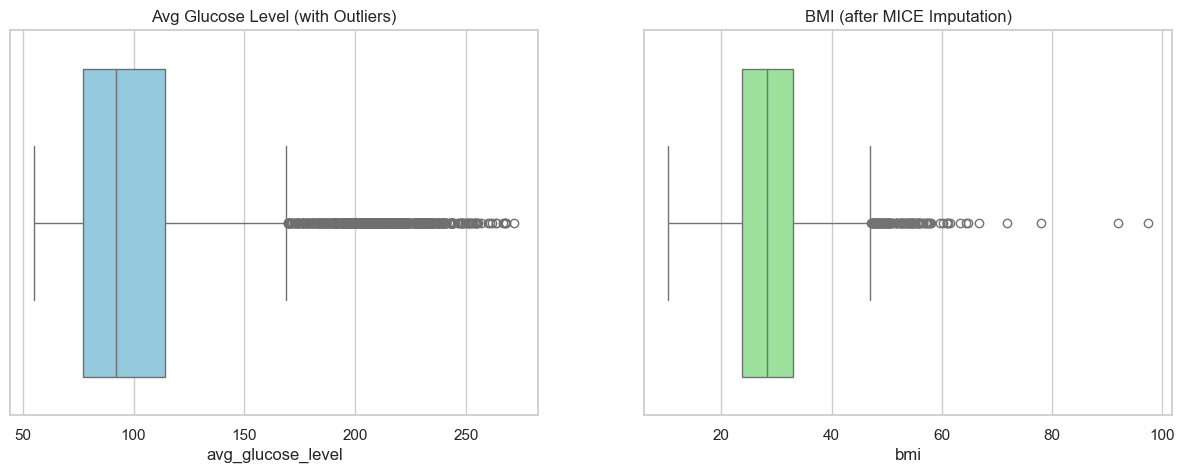

In [2]:
# Cell 2: Advanced Missing Value Imputation (MICE) & Outlier Handling

# 1. Handling Missing Values
# We use MICE (IterativeImputer) as it models the missing 'bmi' based on other features (age, glucose, etc.)
# This is more robust than simple mean imputation for healthcare data.

# First, we need to encode categoricals temporarily for the imputer to work
le = LabelEncoder()
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns

for col in categorical_cols:
    # Handle NaNs in categoricals if any (though usually BMI is the issue here)
    df_encoded[col] = df_encoded[col].astype(str)
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Initialize MICE imputer
mice_imputer = IterativeImputer(max_iter=10, random_state=42)

# Fit and transform
df_imputed_array = mice_imputer.fit_transform(df_encoded)
df_imputed = pd.DataFrame(df_imputed_array, columns=df_encoded.columns)

# Update the original dataframe's BMI with the imputed values
df['bmi'] = df_imputed['bmi']

print(f"Missing values in 'bmi' after MICE imputation: {df['bmi'].isnull().sum()}")

# 2. Outlier Detection (Clinical Measurements)
# We will flag outliers in 'avg_glucose_level' and 'bmi' using the IQR method.
# We won't remove them blindly, but we will visualize them to decide.

def detect_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] < lower_bound) | (data[col] > upper_bound)]

glucose_outliers = detect_outliers(df, 'avg_glucose_level')
bmi_outliers = detect_outliers(df, 'bmi')

print(f"\nPotential outliers detected in Avg Glucose Level: {len(glucose_outliers)}")
print(f"Potential outliers detected in BMI: {len(bmi_outliers)}")

# Visualization of distributions after cleaning
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x=df['avg_glucose_level'], ax=axes[0], color='skyblue').set_title('Avg Glucose Level (with Outliers)')
sns.boxplot(x=df['bmi'], ax=axes[1], color='lightgreen').set_title('BMI (after MICE Imputation)')
plt.show()

### HYPOTHESIS 1: Avg Glucose Level vs. Stroke ###
Shapiro-Wilk (Stroke): p=0.00000
Shapiro-Wilk (No Stroke): p=0.00000
Levene's Test: p=0.00000
>> Assumption violated: Data not normal. Using Mann-Whitney U Test.
Test: Glucose vs Stroke
P-value: 0.00000
Result: Reject Null Hypothesis (Significant Difference)
--------------------------------------------------

### HYPOTHESIS 2: Age vs. Stroke ###
Test: Age vs Stroke (Mann-Whitney U)
P-value: 0.00000
Result: Reject Null Hypothesis (Significant Difference)
--------------------------------------------------

### HYPOTHESIS 3: Work Type vs. Stroke (Categorical Association) ###
Contingency Table:


stroke,0,1
work_type,,
Govt_job,624,33
Never_worked,22,0
Private,2776,149
Self-employed,754,65
children,685,2


Test: Chi-Square Test (Work Type vs Stroke)
P-value: 0.00000
Result: Reject Null Hypothesis (Significant Difference)
--------------------------------------------------


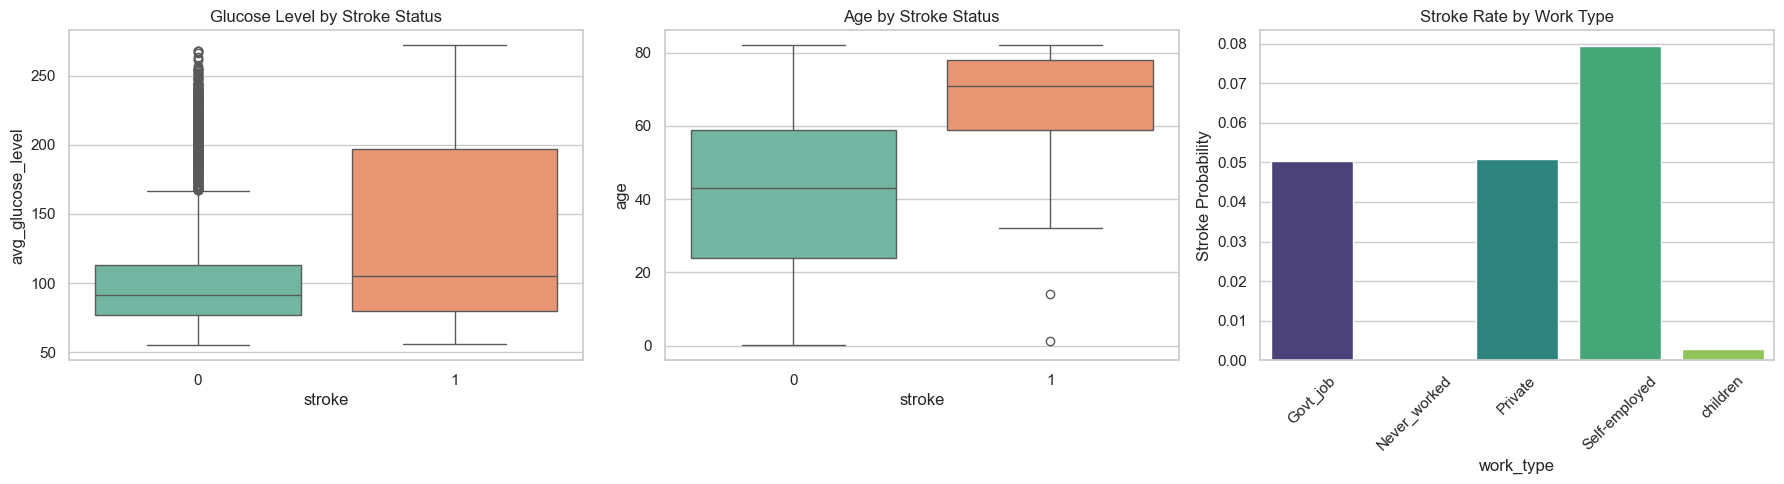

In [6]:
# Cell 3: Statistical Hypothesis Testing
from scipy import stats
import statsmodels.api as sm

# Define a helper function to report results clearly
def report_test(test_name, p_value, alpha=0.05):
    print(f"Test: {test_name}")
    print(f"P-value: {p_value:.5f}")
    if p_value < alpha:
        print("Result: Reject Null Hypothesis (Significant Difference)")
    else:
        print("Result: Fail to Reject Null Hypothesis (No Significant Difference)")
    print("-" * 50)

print("### HYPOTHESIS 1: Avg Glucose Level vs. Stroke ###")
# H0: There is no difference in average glucose levels between patients with and without stroke.
# H1: Patients with stroke have different average glucose levels.

group_stroke = df[df['stroke'] == 1]['avg_glucose_level']
group_no_stroke = df[df['stroke'] == 0]['avg_glucose_level']

# Assumption Check: Normality (Shapiro-Wilk)
shapiro_stroke = stats.shapiro(group_stroke)
shapiro_no_stroke = stats.shapiro(group_no_stroke)
print(f"Shapiro-Wilk (Stroke): p={shapiro_stroke.pvalue:.5f}")
print(f"Shapiro-Wilk (No Stroke): p={shapiro_no_stroke.pvalue:.5f}")

# Assumption Check: Homogeneity of Variances (Levene's Test)
levene_test = stats.levene(group_stroke, group_no_stroke)
print(f"Levene's Test: p={levene_test.pvalue:.5f}")

# Selection of Test
if shapiro_stroke.pvalue < 0.05 or shapiro_no_stroke.pvalue < 0.05:
    print(">> Assumption violated: Data not normal. Using Mann-Whitney U Test.")
    stat, p_val = stats.mannwhitneyu(group_stroke, group_no_stroke)
else:
    print(">> Assumptions met. Using Independent T-Test.")
    stat, p_val = stats.ttest_ind(group_stroke, group_no_stroke, equal_var=(levene_test.pvalue > 0.05))

report_test("Glucose vs Stroke", p_val)


print("\n### HYPOTHESIS 2: Age vs. Stroke ###")
# H0: There is no difference in average Age between patients with and without stroke.
# H1: Patients with stroke have a different average Age.

group_age_stroke = df[df['stroke'] == 1]['age']
group_age_no_stroke = df[df['stroke'] == 0]['age']

# Use Mann-Whitney U directly as Age is often non-normal/skewed in stroke datasets
stat_age, p_val_age = stats.mannwhitneyu(group_age_stroke, group_age_no_stroke)
report_test("Age vs Stroke (Mann-Whitney U)", p_val_age)


print("\n### HYPOTHESIS 3: Work Type vs. Stroke (Categorical Association) ###")
# H0: Work Type and Stroke are independent.
# H1: There is an association between Work Type and Stroke.

# Contingency Table
contingency_table = pd.crosstab(df['work_type'], df['stroke'])
print("Contingency Table:")
display(contingency_table)

# Chi-Square Test
chi2, p_val_chi2, dof, expected = stats.chi2_contingency(contingency_table)
report_test("Chi-Square Test (Work Type vs Stroke)", p_val_chi2)

# Visualization of the significant findings (Updated Syntax)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# FIX: Added hue='stroke' and legend=False to avoid future warnings
sns.boxplot(x='stroke', y='avg_glucose_level', data=df, ax=axes[0], hue='stroke', palette="Set2", legend=False)
axes[0].set_title('Glucose Level by Stroke Status')

# FIX: Added hue='stroke' and legend=False
sns.boxplot(x='stroke', y='age', data=df, ax=axes[1], hue='stroke', palette="Set2", legend=False)
axes[1].set_title('Age by Stroke Status')

# Calculate stroke probability per work type for the bar plot
stroke_prob = contingency_table[1] / (contingency_table[0] + contingency_table[1])
stroke_prob_df = stroke_prob.reset_index(name='prob')

# FIX: Added hue='work_type' and legend=False
sns.barplot(x='work_type', y='prob', data=stroke_prob_df, ax=axes[2], hue='work_type', palette="viridis", legend=False)
axes[2].set_title('Stroke Rate by Work Type')
axes[2].set_ylabel('Stroke Probability')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [7]:
df.to_csv('../data/processed/cleaned_data.csv', index=False)
print("Cleaned data saved to data/processed/cleaned_data.csv")

Cleaned data saved to data/processed/cleaned_data.csv
